In [1]:
!pip install eli5

     |████████████████████████████████| 112kB 8.3MB/s 


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats.stats import kendalltau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import activations
sns.set()

In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *

train_values = np.empty(shape=[0, 222])
test_values = np.empty(shape=[0, 222])

train_sampled_all = glob.glob('./drive/MyDrive/compsci/train_sampled_all_220.csv')
# test_sampled_all = glob.glob('./drive/MyDrive/compsci/test_sampled_all_centered_220.csv')
test_unsampled_all = glob.glob('./drive/MyDrive/compsci/test_unsampled_all_220.csv')

for j in train_sampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)
    
# for j in test_all:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     test_values = np.append(test_values, csvrows, axis=0)

for j in test_unsampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

Loading  ./drive/MyDrive/compsci/train_sampled_all_220.csv
Loading  ./drive/MyDrive/compsci/test_unsampled_all_220.csv
(31912, 222)
(37863, 222)


In [4]:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train_gc = (y_train - y_train.min())/(y_train.max()-y_train.min())*(9-1)
y_test_gc = (y_test - y_test.min())/(y_test.max()-y_test.min())*(9-1)

In [5]:
# use this for all data training and testing

X_train1 = X_train.reshape(X_train.shape + (1,1))
X_test1 = X_test.reshape(X_test.shape + (1,1))

y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

In [6]:
# #use this for per class testing

# class_num = 2

# N_train = train_values
# N_test = test_values[test_values[:,-2]==class_num]

# X_train = N_train[:,:-2]
# X_test = N_test[:,:-2]

# y_train = N_train[:len(N_train),-2]
# y_test = N_test[:len(N_test),-2]

# # y_train = train_values[:len(N_train),-2]
# # y_test = test_values[:len(N_test),-2]

# X_train1 = X_train.reshape(X_train.shape + (1,1,))
# X_test1 = X_test.reshape(X_test.shape + (1,1,))

# y_train1=to_categorical(y_train)
# y_test1=to_categorical(y_test)

In [7]:
#Use this for noisy test data
# r = np.random.normal(0, 1, X_train.shape)
# noise_train = X_train+r
# print(noise_train.shape)
# X_train1 = noise_train.reshape(noise_train.shape + (1,1))

# s = np.random.normal(0, 0.25, X_test.shape)
# noise_test = X_test+s
# print(noise_test.shape)
# X_test1 = noise_test.reshape(noise_test.shape + (1,1))

In [8]:
def showResults(test, pred,model_name):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    recall = recall_score(test, pred, average = 'weighted')
    f1score=f1_score(test, pred, average='weighted') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred)
    print(cm)
    return (model_name,round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

In [9]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 5, 256
activationFunction='relu'

def getlstmModel():
    
    lstmmodel = Sequential()
    lstmmodel.add(LSTM(128, return_sequences=True, input_shape=(X_train1.shape[1],1)))
    lstmmodel.add(LSTM(9, return_sequences=True))
    lstmmodel.add(MaxPooling1D(pool_size=2))
    lstmmodel.add(Flatten())
    lstmmodel.add(Dense(512, activation=tf.nn.relu))    
    lstmmodel.add(Dense(128, activation=tf.nn.relu))    
    lstmmodel.add(Dense(32, activation=tf.nn.relu))
    lstmmodel.add(Dense(9, activation='softmax'))
    lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    lstmmodel.summary()
    return lstmmodel

lstmmodel = getlstmModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 220, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 220, 9)            4968      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 9)            0         
_________________________________________________________________
flatten (Flatten)            (None, 990)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               507392    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

In [10]:
lstmmodelhistory= lstmmodel.fit(X_train1[:,:,:,0], y_train1, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Train on 25529 samples, validate on 6383 samples
Epoch 1/5
25529/25529 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.8067

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 67s 3ms/sample - loss: 0.6148 - accuracy: 0.8067 - val_loss: 0.2360 - val_accuracy: 0.9295
Epoch 2/5
25529/25529 [==============================] - 37s 1ms/sample - loss: 0.1843 - accuracy: 0.9434 - val_loss: 0.1728 - val_accuracy: 0.9466
Epoch 3/5
25529/25529 [==============================] - 35s 1ms/sample - loss: 0.1294 - accuracy: 0.9607 - val_loss: 0.1318 - val_accuracy: 0.9607
Epoch 4/5
25529/25529 [==============================] - 37s 1ms/sample - loss: 0.0870 - accuracy: 0.9731 - val_loss: 0.1077 - val_accuracy: 0.9682
Epoch 5/5
25529/25529 [==============================] - 37s 1ms/sample - loss: 0.0762 - accuracy: 0.9759 - val_loss: 0.0992 - val_accuracy: 0.9709


In [11]:
############## Get CAM ################
import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

get_last_lstm = keras.backend.function([lstmmodel.layers[0].input, keras.backend.learning_phase()], [lstmmodel.layers[1].output])
last_lstm_lstm = get_last_lstm([X_test1[:,:,:,0]])[0]

get_softmax1_lstm = keras.backend.function([lstmmodel.layers[0].input, keras.backend.learning_phase()], [lstmmodel.layers[-1].output])
softmax1_lstm = get_softmax1_lstm(([X_test1[:,:,:,0]]))[0]
softmax_weight1_lstm = lstmmodel.get_weights()[-1]
softmax_weight_lstm = np.reshape(softmax_weight1_lstm,(9,1))

CAM = np.dot(last_lstm_lstm, softmax_weight_lstm)

# for k in range(5):
#     CAM_lstm = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
#     c = np.exp(CAM_lstm) / np.sum(np.exp(CAM_lstm), axis=1, keepdims=True)
#     plt.figure(figsize=(18, 4))
#     plt.plot(X_test1[k].squeeze())
#     plt.scatter(np.arange(len(X_test1[k])), X_test1[k].squeeze(), cmap='inferno_r', c=c[k,:].squeeze(), s=50)
#     # plt.title('True label:' + str(N_test[k,-2]) + '   likelihood of label ' + str(N_test[k,-2]) + ': ' + str(softmax1_lstm[k][int(y_test[k])]))
#     plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax1_lstm[k][int(y_test[k])]))
#     plt.clim(0.003,0.010)
#     plt.colorbar()
# plt.show

In [12]:
lstmpredictions = lstmmodel.predict(X_test1[:,:,:,0], verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy  : 0.9470459287431001
Precision : 0.9691616994551588
Recall : 0.9470459287431001
f1score : 0.9544549872128344
[[26977    28    27   315   986   254   112     4]
 [    4  1646     0     8     0     2     0     0]
 [   25     0  2434     8    26     3     3     1]
 [   23     0     0  1109    16    33    16     2]
 [   42     0     2     6   718     3     2     0]
 [    9     0     1     6     1   176     0     0]
 [    4     0     0     3     2     0   406    13]
 [    0     0     0     1     0     0    14  2392]]
              precision    recall  f1-score   support

           1      0.996     0.940     0.967     28703
           2      0.983     0.992     0.987      1660
           3      0.988     0.974     0.981      2500
           4      0.762     0.925     0.835      1199
           5      0.411     0.929     0.569       773
           6      0.374     0.912     0.530       193
           7      0.734     0.949     0.828       428
           8      0.992     0.994     0

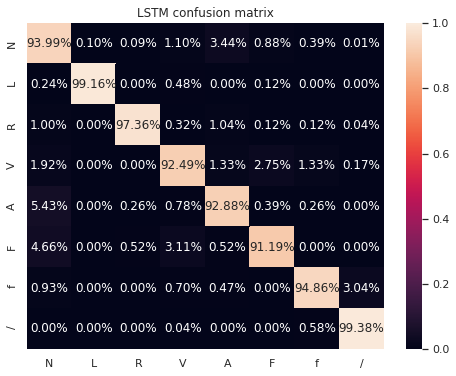

In [13]:
# performance metrics

lstm_predict=np.argmax(lstmpredictions,axis=1)
lstm_actual_value=np.argmax(y_test1,axis=1)
lstm_results = showResults(lstm_actual_value, lstm_predict,'LSTM')
from sklearn import metrics
lstmmetrics = metrics.classification_report(lstm_actual_value, lstm_predict, digits=3)
print(lstmmetrics, 'lstm metrics')
categories=['N','L','R','V','A','F','f','/']
plt.figure(figsize=(8,6))
lstm_cf_m = lstm_results[5].astype('float')/ lstm_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(lstm_cf_m,annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1)
plt.title('LSTM confusion matrix')
plt.show()

In [14]:
# LSTM_results = pd.DataFrame(data=lstm_results,index=('Model','Accuracy','Precision','Recall','F1score','CM'))
# print(LSTM_results)
# LSTM_results.to_csv('lstm_results.csv', encoding='utf-8', index=False)

                                                           0
Model                                                   LSTM
Accuracy                                               0.947
Precision                                              0.969
Recall                                                 0.947
F1score                                                0.954
CM         [[26977, 28, 27, 315, 986, 254, 112, 4], [4, 1...


In [15]:
from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return
a = last_lstm_lstm
new_last_lstm = []
for i in range(len(last_lstm_lstm)):
  means = list(means_of_slices(a[i], 20))
  new_last_lstm.append(means)
new_last_lstm = np.array(new_last_lstm)
print(new_last_lstm.shape)

final_last_lstm = []
for i in new_last_lstm:
  final_last_lstm.append(np.repeat(i,20))
final_last_lstm = np.array(final_last_lstm)
print(final_last_lstm.shape)

(37863, 11)
(37863, 220)


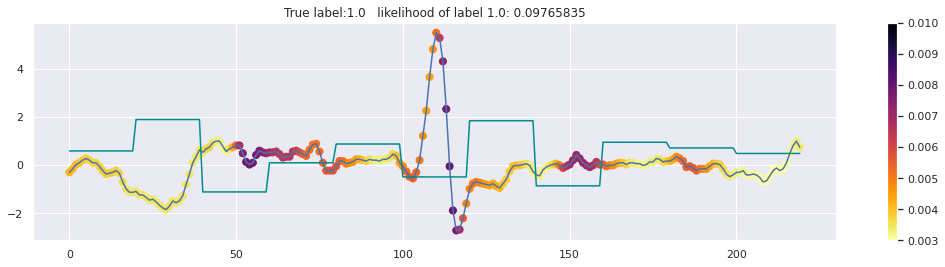

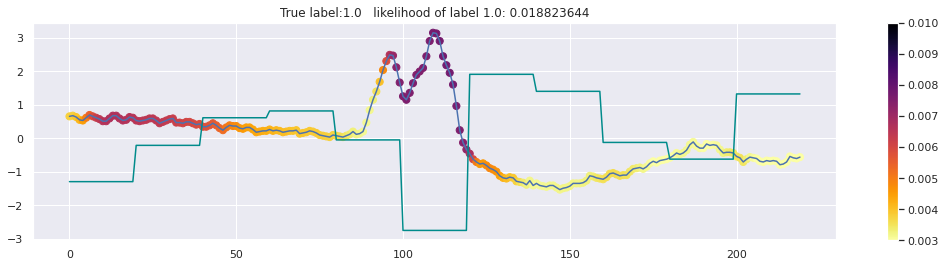

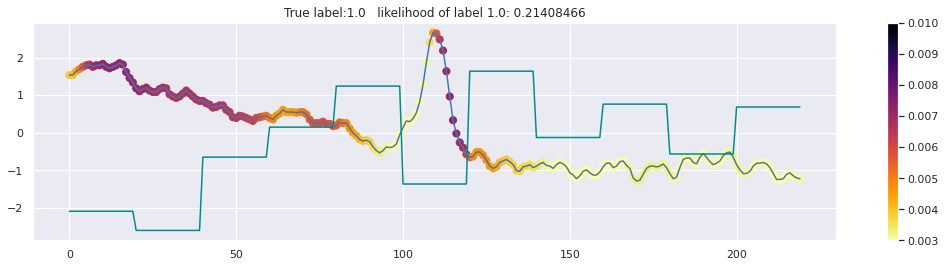

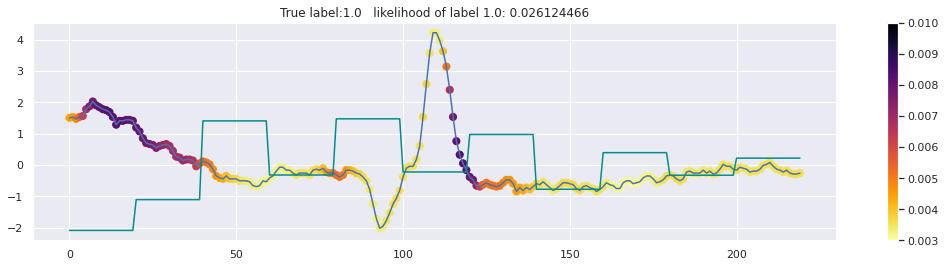

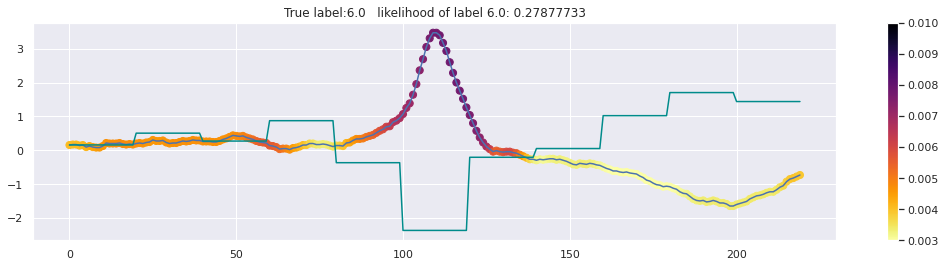

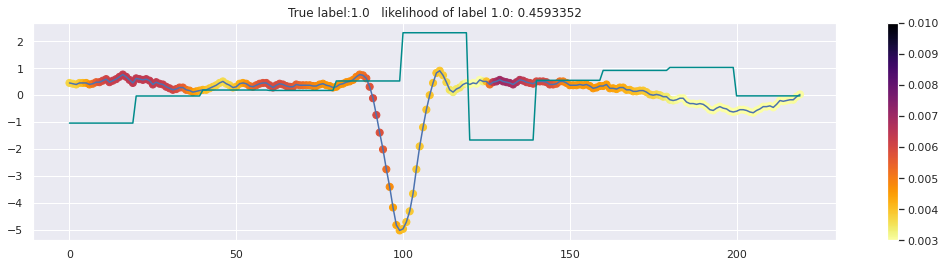

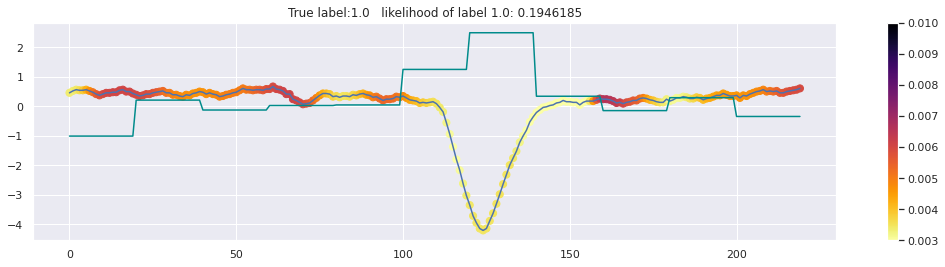

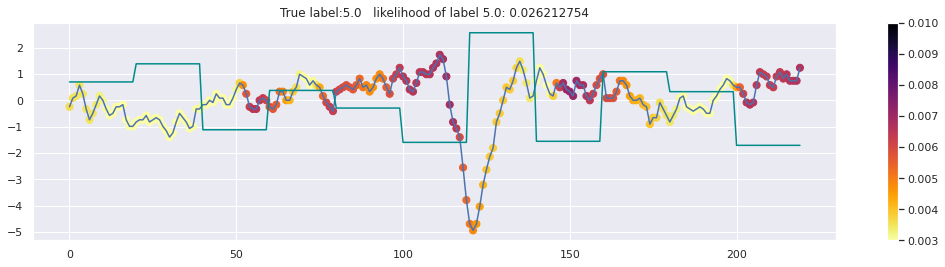

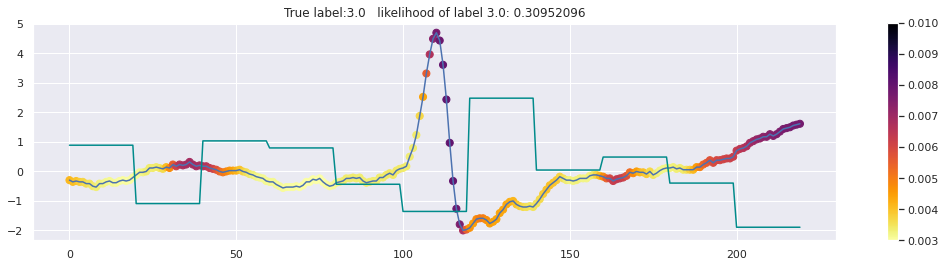

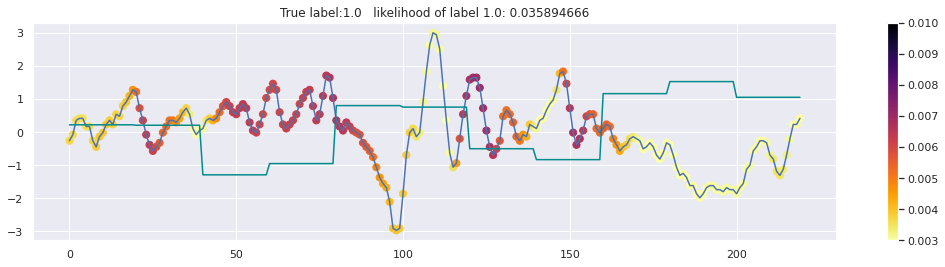

In [16]:
#misclassified saliency
misclass_lstm = np.where(lstm_predict!=lstm_actual_value)
misclass_lstm = misclass_lstm[0].tolist()

for i in misclass_lstm[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_lstm[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

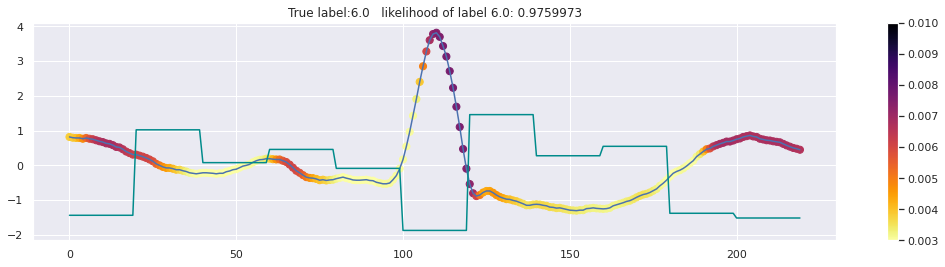

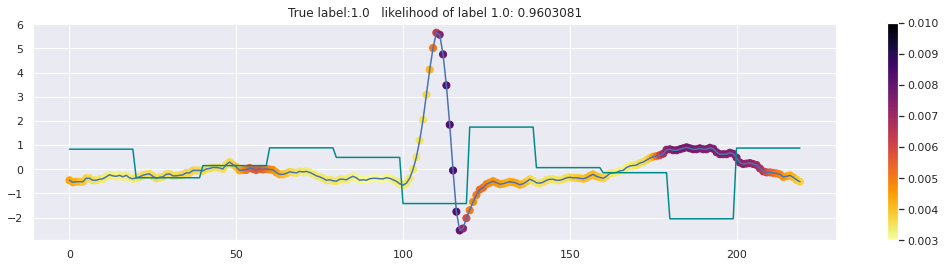

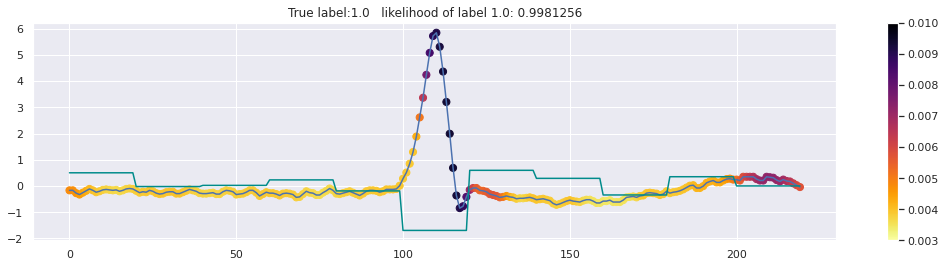

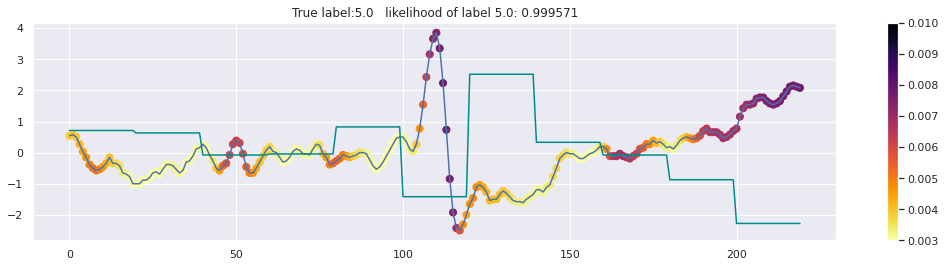

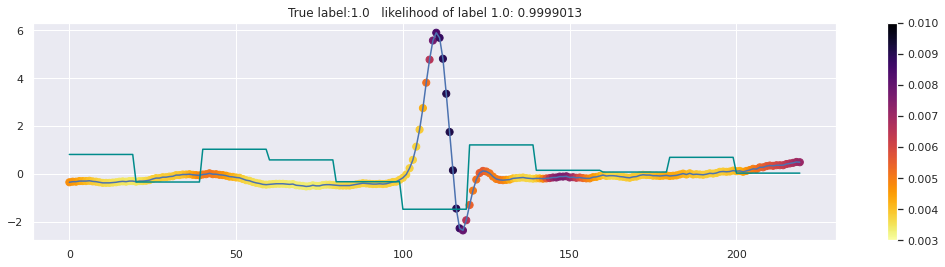

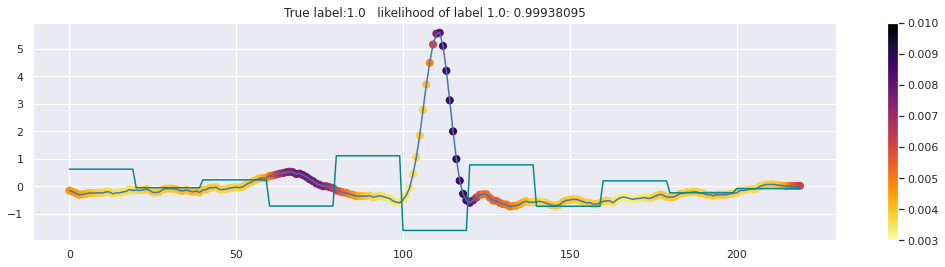

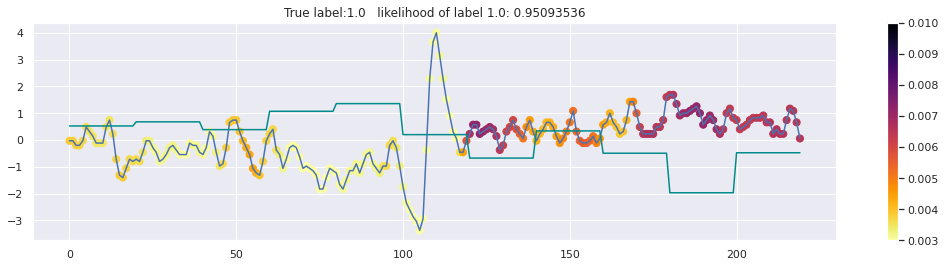

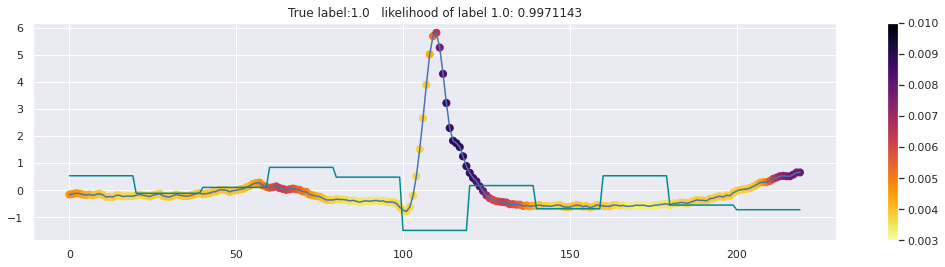

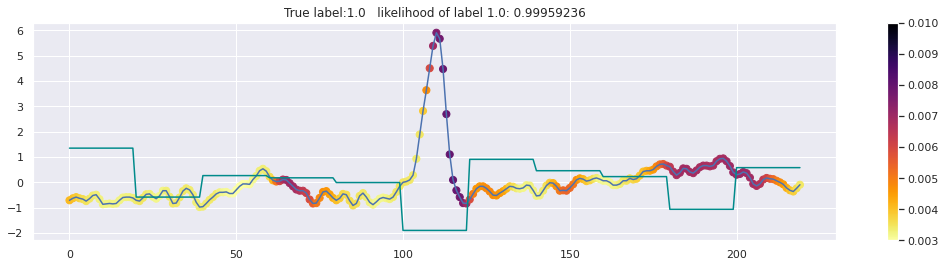

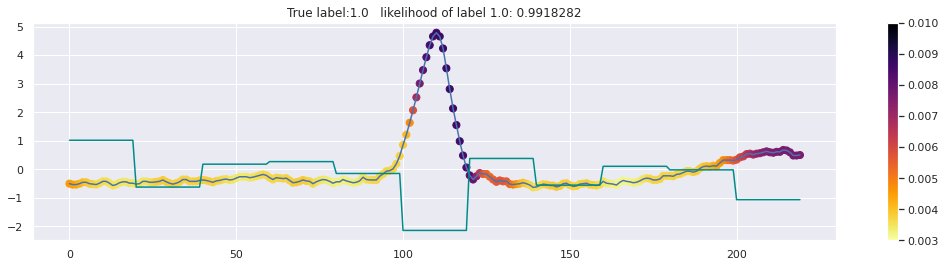

In [17]:
#correct saliency
correct_lstm = np.where(lstm_predict==lstm_actual_value)
correct_lstm = correct_lstm[0].tolist()

for i in correct_lstm[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_lstm[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

In [18]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.neural_network import MLPClassifier

NNMLP_clf = MLPClassifier(random_state=48, max_iter=50)
NNMLP_clf.fit(new_last_lstm, y_test1[:])
perm_all = PermutationImportance(NNMLP_clf).fit(new_last_lstm, y_test1[:])
print('LSTM result')
exp = eli5.explain_weights_df(perm_all, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


LSTM result


In [19]:
perm_corr = PermutationImportance(NNMLP_clf).fit(new_last_lstm[correct_lstm[:]], y_test1[[correct_lstm[:]]])
print('LSTM Correct results')
exp_corr = eli5.explain_weights_df(perm_corr, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


LSTM Correct results


In [20]:
perm_mis = PermutationImportance(NNMLP_clf).fit(new_last_lstm[misclass_lstm[:]], y_test1[misclass_lstm[:]])
print('LSTM Misclass results')
exp_mis = eli5.explain_weights_df(perm_mis, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

LSTM Misclass results


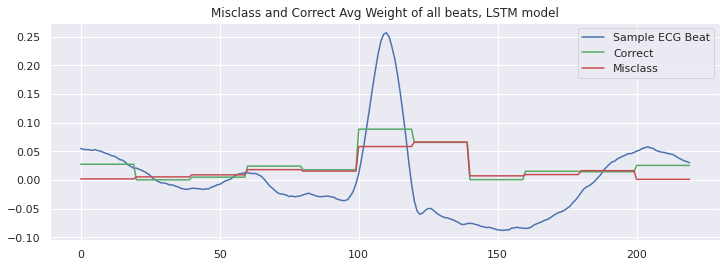

In [21]:
from sklearn.preprocessing import normalize

n0= normalize(final_last_lstm[correct_lstm[:]])
n1= normalize(final_last_lstm[misclass_lstm[:]])
n2= normalize(X_test1[:,:,0,0])

m0=n0.mean(axis=0)
m1=n1.mean(axis=0)

plt.figure(figsize=(12,4))
plt.plot(n2[0],color='b',label='Sample ECG Beat')
plt.plot(np.abs(m0),color='g',label='Correct')
plt.plot(np.abs(m1),color='r',label='Misclass')
# plt.title('Class: N, Number: ' + str(class_num))
# plt.title('Misclass and Correct Avg Weight of F class, LSTM model')
# plt.title('Misclass and Correct Avg Weight of F class on 0.25 std Noise, LSTM model')
plt.title('Misclass and Correct Avg Weight of all beats, LSTM model')
plt.legend()
plt.show()

In [22]:
# # saving the model

# model_json = lstmmodel.to_json()
# with open("NEWlstmmodel_testunsam.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# lstmmodel.save_weights("NEWlstmmodel_testunsam_weights.h5")
# lstmmodel.save("NEWlstmmodel_testunsam.h5")
# print("Saved model to disk")

In [23]:
#done on GRAD-CAM

from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return
a = np.dot(last_lstm_lstm, softmax_weight_lstm)
new_last_lstm = []

for i in range(len(last_lstm_lstm)):
  means = list(means_of_slices(a[i], 20))
  new_last_lstm.append(means)
new_last_lstm = np.array(new_last_lstm)
print(new_last_lstm.shape)

final_last_lstm = []
for i in new_last_lstm:
  final_last_lstm.append(np.repeat(i,20))
final_last_lstm = np.array(final_last_lstm)
print(final_last_lstm.shape)

(37863, 11)
(37863, 220)


In [28]:
exp = exp.sort_values(by=['feature'])
exp_corr = exp_corr.sort_values(by=['feature'])
exp_mis = exp_mis.sort_values(by=['feature'])

exp.to_csv('lstm_pfi.csv', encoding='utf-8', index=False)
exp_corr.to_csv('lstm_pfi_corr.csv', encoding='utf-8', index=False)
exp_mis.to_csv('lstm_pfi_mis.csv', encoding='utf-8', index=False)

lstm_pfi = exp.weight.values
lstm_pfi

array([0.06867919, 0.01437815, 0.03164567, 0.02516441, 0.04995378,
       0.12486596, 0.19135832, 0.19400998, 0.05731189, 0.08053773,
       0.06838866])

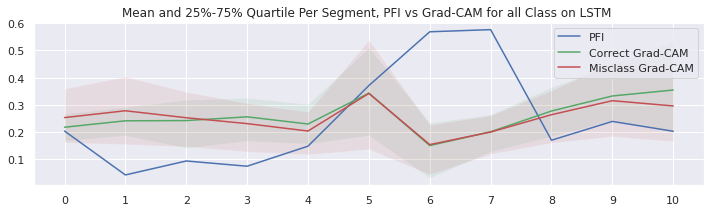

In [25]:
lstm_pfi = normalize(lstm_pfi.reshape(1,-1))
lstm_pfi = lstm_pfi.ravel()

lstm_grad_corr = normalize(new_last_lstm[correct_lstm[:]])
lstm_grad_mis = normalize(new_last_lstm[misclass_lstm[:]])

lstm_grad_corr = np.abs(lstm_grad_corr)
lstm_grad_mis = np.abs(lstm_grad_mis)

corr = pd.DataFrame(lstm_grad_corr)
df_corr = pd.DataFrame({'mean': corr.mean(), 'median': corr.median(),
                   '25%': corr.quantile(0.25), '50%': corr.quantile(0.5),
                   '75%': corr.quantile(0.75)})

mis = pd.DataFrame(lstm_grad_mis)
df_mis = pd.DataFrame({'mean': mis.mean(), 'median': mis.median(),
                   '25%': mis.quantile(0.25), '50%': mis.quantile(0.5),
                   '75%': mis.quantile(0.75)})

plt.figure(figsize=(12,3))
plt.plot(lstm_pfi,color='b',label='PFI')
plt.plot(df_corr['mean'],color='g',label='Correct Grad-CAM')
plt.fill_between(np.arange(11), df_corr['25%'], df_corr['75%'], alpha=0.1, facecolor="g")
plt.plot(df_mis['mean'],color='r',label='Misclass Grad-CAM')
plt.fill_between(np.arange(11), df_mis['25%'], df_mis['75%'], alpha=0.1, facecolor="r")
plt.title('Mean and 25%-75% Quartile Per Segment, PFI vs Grad-CAM for all Class on LSTM ')
plt.xticks(ticks=(0,1,2,3,4,5,6,7,8,9,10))
plt.legend()
plt.show()